In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import pickle #To use cifar-10

%matplotlib inline

In [2]:
#Load trainset_CIFAR_10
#https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle_trainset_CIFAR_10(file):
    dicts = dict()
    for i in range(1, 6):   #This dataset is divided into 5 files.
        if i == 1:
            file_dict = pickle.load(open(file + str(i), 'rb'), encoding = 'bytes')
            dicts[b'data'] = file_dict[b'data']
            dicts[b'labels'] = file_dict[b'labels']
        else:
            file_dict = pickle.load(open(file + str(i), 'rb'), encoding = 'bytes')
            dicts[b'data'] = np.concatenate((dicts[b'data'], file_dict[b'data']))
            dicts[b'labels'] += file_dict[b'labels']
    return dicts

#Load testset_CIFAR_10
def unpickle_testset_CIFAR_10(file):
    dicts = pickle.load(open(file, 'rb'), encoding = 'bytes')
    return dicts

#Load MNIST
#http://yann.lecun.com/exdb/mnist/
def unpickle_MNIST(image, label):
    #Read Image data
    image_set = open(image, 'rb')
    magic_number = struct.unpack(">i", image_set.read(4))[0]
    number_images = struct.unpack(">i", image_set.read(4))[0]
    rows = struct.unpack(">i", image_set.read(4))[0]
    cols = struct.unpack(">i", image_set.read(4))[0]
    image_set_data = np.reshape(np.fromstring(image_set.read(), dtype = np.uint8), (number_images, rows * cols))
    image_set.close()
    #Read Label data
    label_set = open(label, 'rb')
    magic_number = struct.unpack(">i", label_set.read(4))[0]
    number_of_items = struct.unpack(">i", label_set.read(4))[0]
    label_set_data = np.reshape(np.fromstring(label_set.read(), dtype = np.uint8), (number_of_items))
    label_set.close()    
    return image_set_data, label_set_data

In [3]:
def shuffle(X, y):
    """
    Argument:
    X -- all training_data
    y -- all training_label
    
    Return:
    X_train -- training_dataset
    y_train -- training_labelset
    X_cross -- cross_validation_dataset
    y_cross -- cross_validation_labelset
    """
    data_count = X.shape[0]
    shuffle_order = np.arange(data_count)
    np.random.shuffle(shuffle_order)
    X_train, y_train = X[shuffle_order][:(4 * data_count) // 5], y[shuffle_order][:(4 * data_count) // 5]
    X_cross, y_cross = X[shuffle_order][(4 * data_count) // 5:], y[shuffle_order][(4 * data_count) // 5:]
    return X_train, y_train, X_cross, y_cross

In [50]:
class Neural_network():
    def __init__(self):
        pass
    
    def train(self, X_train, y_train, layers, alpha = 1, regularization = [0], iterations = 5000, check = False):
        """
        Argument:
        X_train -- training_data
        y_train -- training_label
        layers -- size of layers
        learning_rate -- learning_rate(alpha) of gradient descent. default value is 1
        regularization -- list. to find best regularization value. default is [0]
        iterations -- number of iterations of the optimization loop. default value is 5000
        check -- if check is True, check the analytic gradient through a numerical gradient. default value is False

        Store:
        W -- python dictionary. W[k] is k's layer weights matrix
        b -- python dictionary. b[k] is k's layer bias vector(1-dimension matrix)
        dW -- python dictionary. gradient of weights.
        db -- python dictionary. gradient of bias.
        lossindex, loss -- save value of iterations(index), save value of loss functions.         
        """
        if layers < 1:
            raise ValueError("Please increase layer size over 0")
        self.X_train = X_train / 255 # To prevent overflow
        self.y_train = y_train
        self.W = dict()
        self.b = dict()
        self.dW = dict()
        self.db = dict()
        self.layer = layers
        kindofclass = 10
        N = self.X_train.shape[0]
        # To calculate layersize, e.g, (3000, 2000), (2000, 1000), (1000, 10).
        layersize = [((self.X_train.shape[1] * (layers - i)) + (kindofclass * i)) // layers for i in range(layers + 1)]
        self.lossindex = []
        self.loss = []
        print(layersize)
        for i in range(layers):
            # initialize for each weight, bias factor, (Xavier initialize)
            self.W[i] = np.random.randn(layersize[i], layersize[i + 1]).astype(np.float64) * (np.sqrt(2.0 / layersize[i]))
            self.b[i] = np.zeros(layersize[i + 1]).astype(np.float64)
            print(self.W[i].shape, self.b[i].shape)
        for lambd in regularization:
            for iters in range(1, iterations + 1):
                # Dynamic programming
                hidden = dict()
                hidden[0] = self.X_train
                self.calculate_hidden_layer(hidden)
                if iters % 10 == 0:
                    self.lossindex.append(iters)
                    self.loss.append(self.calculate_loss(lambd, hidden[layers], self.y_train))
                # Softmax differential
                hidden[layers][np.arange(N), self.y_train] -= 1
                self.gradient(lambd, hidden)
                if check == True:
                    checkdW, checkdb = self.gradient_check(lambd)
                    for i in self.dW:
                        print(iters, "iterations")
                        print("gradient W%d" % i)
                        print(self.dW[i][:3, :3])
                        print("numerical W%d" % i)
                        print(checkdW[i][:3, :3])
                        print("gradient b%d" % i)
                        print(self.db[i][:3])
                        print("numerical b%d" % i)
                        print(checkdb[i][:3])
                    if iters == 2:
                        check = False
                # update W, b
                for i in self.W:
                    self.W[i] -= alpha / iters * self.dW[i]
                    self.b[i] -= alpha / iters * self.db[i]
                if iters % 500 == 0:
                    print(iters, "iterations finished")
    
    def calculate_hidden_layer(self, hidden):
        # Calculate hidden layer, activation function: Leaky ReLU(0.01), classifier function: Softmax
        for i in range(self.layer):
            if i < self.layer - 1:
                hidden[i + 1] = np.matmul(hidden[i], self.W[i]) + self.b[i]
                hidden[i + 1][hidden[i + 1] < 0] *= 0.01
            else:
                temp = np.exp(np.matmul(hidden[i], self.W[i]) + self.b[i])
                hidden[i + 1] = temp / np.sum(temp, axis = 1, keepdims = True)

    def calculate_loss(self, lambd, y_hat, y):
        """
        Argument:
        lambd -- Regularization value
        y_hat -- matrix which applied classifier.
        y -- training_label
        
        Return:
        loss -- value of loss function.
        """
        N = self.X_train.shape[0]
        loss = -np.sum((np.log(y_hat)[np.arange(N), y])) / N
        for i in self.W:
            loss += lambd / 2 / N * np.sum(self.W[i] ** 2)
        return loss

    def gradient(self, lambd, hidden):
        """
        Argument:
        lambd -- Regularization value
        hidden -- dictionary, calculated value of hidden layers.
        
        Store:
        dW -- dictionary, gradient matrix about W.
        db -- dictionary, gradient matrix about b.
        """
        tempW = None
        tempb = None
        N = self.X_train.shape[0]
        #back propagation
        for i in range(self.layer - 1, -1, -1):
            #softmax diffrential
            if i == self.layer - 1:
                hidden[i + 1] /= N
                tempW, tempb = hidden[i + 1], hidden[i + 1]
                self.dW[i] = (np.matmul(hidden[i + 1].T, hidden[i]).T) + lambd / N * self.W[i]
                self.db[i] = np.sum(tempb, axis = 0)
            #Leaky ReLU diffrential
            else:
                tempW = np.matmul(tempW, self.W[i + 1].T)
                tempW[hidden[i + 1] < 0] *= 0.01
                self.dW[i] = np.matmul(tempW.T, hidden[i]).T + lambd / N * self.W[i]
                tempb = np.matmul(tempb, self.W[i + 1].T)
                tempb[hidden[i + 1] < 0] *= 0.01
                self.db[i] = np.sum(tempb, axis = 0)
                
    
    def gradient_check(self, lambd, h = 0.0001):
        """
        Argument:
        h -- very small positive number, default value is 0.00001.
        
        Return:
        checkdW -- Dictionary of gradient matrix W (numerical)
        checkdb -- Dictionary of gradient matrix b (numerical)
        """
        # Use dy/dx = lim(x->0)(f(x + h) - f(x - h) / (2 * h))        
        # numerical gradient_check
        checkdW = dict()
        checkdb = dict()
        hidden = dict()
        hidden[0] = self.X_train
        for key in self.W:
            checkdW[key] = np.zeros((4, 4))
            for i in range(4):
                for j in range(4):
                    self.W[key][i][j] += h
                    self.calculate_hidden_layer(hidden)
                    loss1 = self.calculate_loss(lambd, hidden[self.layer], self.y_train)
                    self.W[key][i][j] -= 2 * h
                    self.calculate_hidden_layer(hidden)
                    loss2 = self.calculate_loss(lambd, hidden[self.layer], self.y_train)
                    checkdW[key][i][j] = (loss1 - loss2) / h / 2
                    self.W[key][i][j] += h
        for key in self.b:
            checkdb[key] = np.zeros(4)
            for i in range(4):
                self.b[key][i] += h
                self.calculate_hidden_layer(hidden)
                loss1 = self.calculate_loss(lambd, hidden[self.layer], self.y_train)
                self.b[key][i] -= 2 * h
                self.calculate_hidden_layer(hidden)
                loss2 = self.calculate_loss(lambd, hidden[self.layer], self.y_train)
                checkdb[key][i] = (loss1 - loss2) / h / 2
                self.b[key][i] += h
        return checkdW, checkdb
    
    def predict(self, X_test):
        """
        Argument:
        X_test -- test_data
        
        Return:
        constant_value -- predicted label number
        """
        arr = X_test.copy() / 255
        for i in range(self.layer):
            arr = np.matmul(arr, self.W[i]) + self.b[i]
            if i < self.layer - 1:
                arr[arr < 0] *= 0.01
            else:
                return arr.argmax(axis = 1)
    
    def accuracy(self, X_test, y_test):
        """
        Argument:
        X_test -- test_data
        y_test -- test_label
        
        Return:
        value -- accuracy of classifier
        """
        return np.mean(self.predict(X_test) == y_test) * 100

In [54]:
# MNIST
train_image_name = "mnist\\train-images.idx3-ubyte"
train_label_name = "mnist\\train-labels.idx1-ubyte"
test_image_name = "mnist\\t10k-images.idx3-ubyte"
test_label_name = "mnist\\t10k-labels.idx1-ubyte"

X, y = unpickle_MNIST(train_image_name, train_label_name)
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = unpickle_MNIST(test_image_name, test_label_name)

NN_mnist = Neural_network()
NN_mnist.train(X_train[:500], y_train[:500], layers = 2, iterations = 5000, check = True)

[784, 397, 10]
(784, 397) (397,)
(397, 10) (10,)
1 iterations
gradient W1
[[-0.01137452  0.00910532 -0.04946031]
 [-0.02784783  0.0220368   0.00057367]
 [ 0.00242858 -0.00388049  0.00057639]]
numerical W1
[[-0.01137452  0.00910532 -0.04946031]
 [-0.02784783  0.0220368   0.00057367]
 [ 0.00242858 -0.00388049  0.00057639]]
gradient b1
[ 0.02177431  0.01464371 -0.04271953]
numerical b1
[ 0.02177431  0.01464371 -0.04271953]
1 iterations
gradient W0
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
numerical W0
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
gradient b0
[ 0.00241379  0.00973529 -0.00018915]
numerical b0
[ 0.00241379  0.00973529 -0.00018915]
2 iterations
gradient W1
[[-0.00852749 -0.04338369  0.11434328]
 [ 0.00108236 -0.0026464   0.0074241 ]
 [ 0.0008511  -0.00807392  0.0095279 ]]
numerical W1
[[-0.00852749 -0.04338369  0.11434328]
 [ 0.00108236 -0.0026464   0.0074241 ]
 [ 0.0008511  -0.00807392  0.0095279 ]]
gradient b1
[-0.00076855 -0.08627306  0.30434266]
numerical b1
[-0.0007

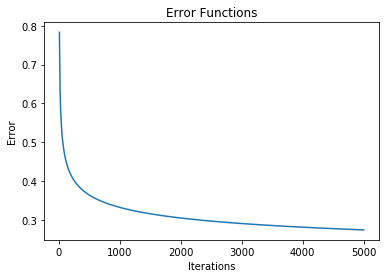

In [55]:
#Visualizing Error Curve
plt.plot(NN_mnist.lossindex, NN_mnist.loss)
plt.title("Error Functions")
plt.xlabel('Iterations')
plt.ylabel('Error')

In [57]:
print("Test set accuracy is ", NN_mnist.accuracy(X_test, y_test))
print("Train set accuracy is ", NN_mnist.accuracy(X_train[:300], y_train[:300]))

Test set accuracy is  84.94
Train set accuracy is  97.0


Number of this picture is 9
Prediction =  9


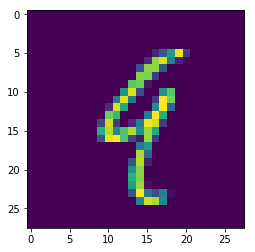

In [59]:
def onesample(self, X_test):
    arr = X_test.copy() / 255
    for i in range(self.layer):
        arr = np.matmul(arr, self.W[i]) + self.b[i]
        if i < self.layer - 1:
            arr[arr < 0] *= 0.01
        else:
            return arr.argmax()


#Visualizing MNIST
X = X_train.reshape(48000, 28, 28)
i = np.random.choice(range(len(X)))
plt.imshow(X[i], interpolation = 'nearest')
print("Number of this picture is", y_train[i])
print("Prediction = ", onesample(NN_mnist, X_train[i]))

In [60]:
file_name = 'cifar-10\data_batch_'
datadict = unpickle_trainset_CIFAR_10(file_name)
file_name = 'cifar-10\\test_batch'
testdict = unpickle_testset_CIFAR_10(file_name)
classlist = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

X, y = datadict[b'data'], np.array(datadict[b'labels'])
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = testdict[b'data'], np.array(testdict[b'labels'])

a = Neural_network()
a.train(X_train[:500], y_train[:500], layers = 3, iterations = 3000, check = False)

[3072, 2051, 1030, 10]
(3072, 2051) (2051,)
(2051, 1030) (1030,)
(1030, 10) (10,)


KeyboardInterrupt: 

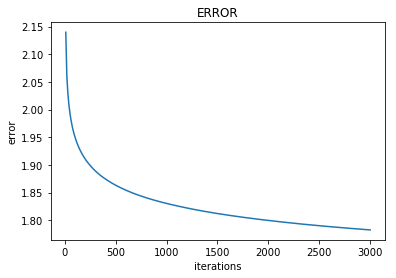

In [187]:
plt.plot(a.lossindex, a.loss)
plt.xlabel("iterations")
plt.ylabel("error")
plt.title("ERROR")

In [190]:
findx, findy = X_train[:100] / 255, y_train[:100]
for i in range(3):
    findx = np.matmul(findx, a.W[i]) + a.b[i]
print(findx)
print(findy)
find = findx.argmax(axis = 1)
print(find)
print(np.mean(find == findy))


[[ -1.90073023e+00   3.44465976e-01  -7.27730525e-01  -8.68002104e-01
    9.77033046e-01  -8.49641224e-01  -6.05432597e-01   2.87336698e+00
   -1.32258124e+00  -5.22309944e-01]
 [ -1.95640487e+00   1.14484038e+00  -4.54220291e-01  -3.05751217e-01
    5.72488522e-01   2.19058567e-01  -1.14979037e+00   2.81243452e+00
   -2.13512459e+00  -1.63088306e+00]
 [ -1.62877529e-01   8.16423317e-01  -1.22669562e+00  -3.47553095e-01
    4.17738026e-01  -2.79326871e+00  -9.18765965e-01   2.16989089e+00
   -6.15702339e-01  -2.00430541e-01]
 [ -1.94607188e+00   5.88883448e-01  -4.83118458e-01   4.78212116e-01
    1.46632568e+00  -2.74014950e-01   9.47706521e-01   2.80851127e+00
   -3.83984594e+00  -1.70614433e+00]
 [ -2.03499704e+00   7.50192693e-02  -1.56406982e+00  -3.39644998e-01
    9.18593225e-01  -9.75508708e-01   6.10554407e-01   2.85221147e+00
   -3.16040022e+00  -8.22720990e-01]
 [ -8.28442434e-01   1.11019681e+00  -2.72835921e-01   5.24237908e-02
    1.39102219e+00  -1.83296174e+00  -6.38084